In [2]:
# importing necessary packages
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [105]:
import seaborn as sns

In [71]:
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
# one hot encoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import check_X_y

In [9]:
import spacy

nlp = spacy.load("en", disable=['parser','tagger','ner'])

In [10]:
subreddit_train = "subreddit_train.json"
subreddit_test = "subreddit_test.json"

In [11]:
train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)

In [12]:
# columns
print(list(train_threads.columns.values))

['is_self_post', 'posts', 'subreddit', 'title', 'url']


In [13]:
# training data size
print(train_threads.size)

7280


In [14]:
train_threads.head()

,is_self_post,posts,subreddit,title,url
0,1.0,"[{'majority_link': 't3_2x19a2', 'majority_type...",relationships,How do I [23F] communicate with my self-center...,https://www.reddit.com/r/relationships/comment...
1,1.0,"[{'majority_link': 'none', 'url': 'https://www...",summonerschool,What Cherry switch do you recommend for League...,https://www.reddit.com/r/summonerschool/commen...
2,1.0,"[{'majority_link': 'none', 'annotations': [{'m...",askreddit,Where do memes go when they die?,https://www.reddit.com/r/AskReddit/comments/4d...
3,1.0,"[{'majority_link': 't3_1h300m', 'majority_type...",trees,Some weird long term affects??,https://www.reddit.com/r/trees/comments/1h300m...
4,1.0,"[{'majority_link': 'none', 'majority_type': 'q...",buildapc,Simple question: If I install Windows to a sta...,https://www.reddit.com/r/buildapc/comments/jhb...


In [15]:
cols_to_drop = ['is_self_post', 'url']
train = train_threads.drop(cols_to_drop, axis=1)
test = test_threads.drop(cols_to_drop, axis=1)

In [16]:
def posts_parse(x):
    
    j = json.loads(x)
    
    return j

In [17]:
len(train['posts'][0])

7

In [18]:
def parse_posts(x):
    '''parses `posts` in json format and
        returns the `body` attribute '''
    data = json_normalize(x)
    return list(data['body'])

In [19]:
def parse_author(x):
    '''parses `posts` in json format and
        returns the `author` attribute '''
    try:
        data = json_normalize(x)
        return list(data['author'])
    
    except KeyError as e:
        return list() 
    
    

In [20]:
def extract_all_data(df):
    '''
    function to parse json data and extract the `body` attribute,
    extract each textual data from every post,
    convert and return a pandas data-frame
    '''
    
    # extracting all posts from json type column
    all_posts = df['posts'].apply(parse_posts)
    all_authors = df['posts'].apply(parse_author)
    
    text_data = [] # all text data
    label_data = [] # all labels
    author_data = [] # all author
    title_data = [] # all title
    
    # extract all textual data in each post
    for post_idx, (post, author) in enumerate(zip(all_posts, all_authors)):
        
        for text, au in zip(post, author):
            text_data.append(text)
            label_data.append(df.subreddit[post_idx])
            author_data.append(au)
            title_data.append(df.title[post_idx])
            
    # converting the text-labels into pandas DataFrame
    data = pd.DataFrame(text_data)
    data['subreddit'] = label_data
    data['author'] = author_data
    data['title'] = title_data
    
    data.columns = ['text', 'subreddit', 'author', 'title'] 
    
    return data

In [21]:
train_fin = extract_all_data(train)
test_fin = extract_all_data(test)

In [22]:
# filling null author values with value='unknown'
train_fin.author.fillna('unknown', axis=0, inplace=True)

In [23]:
# check for empty `text` fields
def check_empty(x):
    if x=='' or x==' ':
        return True
    else:
        return False

In [24]:
# getting the indexed of the empty rows
empty_rows_tr = train_fin.text[train_fin.text.apply(check_empty)].index.values
empty_rows_te = test_fin.text[test_fin.text.apply(check_empty)].index.values

In [25]:
print('No of empty rows in the train data:', len(empty_rows_tr))
print('No of empty rows in the test data:', len(empty_rows_te))

No of empty rows in the train data: 293
No of empty rows in the test data: 61


In [26]:
# dropping the empty rows
train_fin.drop(empty_rows_tr, inplace=True)
test_fin.drop(empty_rows_te, inplace=True)

In [27]:
# checking the size of the dataset
print(train_fin.size)
print(test_fin.size)

59756
15800


In [28]:
# explicitly converting `text` column to `str` type
train_fin = train_fin.astype(str)
test_fin = test_fin.astype(str)

In [29]:
# import stopwords
stops = nlp.Defaults.stop_words
punct = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

In [30]:
def clean_text_data(x, lowercase=True):
    '''
    preprocessing data.
    removing stopwords & punctuation
    '''
    if lowercase:
        x = x.lower()
    x = nlp(x)
    lemmatized = list()
    for word in x:
        lemma = word.lemma_.strip()
        #print(lemma)
        
        if lemma not in stops and lemma not in punct:
            lemmatized.append(lemma)
    
    return " ".join(lemmatized)

In [31]:
train_fin.text = train_fin.text.apply(clean_text_data)
test_fin.text = test_fin.text.apply(clean_text_data)

In [32]:
train_fin.columns

Index(['text', 'subreddit', 'author', 'title'], dtype='object')

In [33]:
# selecting top 20 classes with maximum examples
top_20_cols = list(train_fin.groupby(by='subreddit').count().sort_values(by='text',
                                                      ascending=False).head(20).index)

In [34]:
top_20_cols

['askreddit',
 'leagueoflegends',
 'buildapc',
 'electronic_cigarette',
 'pcmasterrace',
 'trees',
 'gaming',
 'relationships',
 'explainlikeimfive',
 'whowouldwin',
 'summonerschool',
 'techsupport',
 'movies',
 'atheism',
 'jailbreak',
 'starcraft',
 'hearthstone',
 'personalfinance',
 'tipofmytongue',
 'reddit.com']

In [35]:
print('Train size before dropping low-freq classes:',train_fin.size)
print('Test size before dropping low-freq classes:',test_fin.size)

Train size before dropping low-freq classes: 59756
Test size before dropping low-freq classes: 15800


In [36]:
def return_indexes_to_drop(x):
    '''
    returns indexes of rows to drop in the dataframe
    '''
    ret = 0
    if x in top_20_cols:
        return False
    else:
        return True

In [37]:
train_fin['drop'] = train_fin.subreddit.apply(return_indexes_to_drop)
test_fin['drop'] = test_fin.subreddit.apply(return_indexes_to_drop)

In [38]:
print('Train size after dropping low-freq classes:',train_fin.size)
print('Test size after dropping low-freq classes:',test_fin.size)

Train size after dropping low-freq classes: 74695
Test size after dropping low-freq classes: 19750


In [39]:
train_fin.drop('drop', axis=1, inplace=True)
test_fin.drop('drop', axis=1, inplace=True)

In [40]:
# sorted `subreddit` files 
sorted(test_fin.subreddit.unique())

['askreddit',
 'atheism',
 'buildapc',
 'electronic_cigarette',
 'explainlikeimfive',
 'gaming',
 'hearthstone',
 'jailbreak',
 'leagueoflegends',
 'movies',
 'pcmasterrace',
 'personalfinance',
 'reddit.com',
 'relationships',
 'starcraft',
 'summonerschool',
 'techsupport',
 'tipofmytongue',
 'trees',
 'whowouldwin']

In [41]:
# encoding subreddit

train_y = np.array(train_fin.subreddit)
test_y = np.array(test_fin.subreddit)

## Q1

In [101]:
# vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# metrics
from sklearn.metrics import (accuracy_score,f1_score,
                             precision_score,recall_score)
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
# initializing vectorizer
count_vec = CountVectorizer()
tfidf_vec = TfidfVectorizer()

In [147]:
# one-hot-encoding
count_vec.fit_transform(
    train_fin.text.append(test_fin.text))
train_text_count_vec = count_vec.transform(train_fin.text)
test_text_count_vec = count_vec.transform(test_fin.text)

# tfidf encoding
tfidf_vec.fit_transform(
    train_fin.text.append(test_fin.text))
train_text_tfidf_vec = tfidf_vec.transform(train_fin.text)
test_text_tfidf_vec = tfidf_vec.transform(test_fin.text)

In [150]:
models = [('lr',LogisticRegression()),
        #('svc', SVC()),
        ('gnb',GaussianNB()),
        ('dum-strat',DummyClassifier(strategy='stratified')),
        ('dum-mf',DummyClassifier(strategy='most_frequent'))]

In [151]:
def evaluate_func(test_y, pred):
    
    print('Evaluating..')
    
    a = accuracy_score(test_y, pred)
    f = f1_score(test_y, pred, average='macro')
    p = precision_score(test_y, pred, average='macro')
    r = recall_score(test_y, pred, average='macro')
    
    print('Accuracy Score  : {:.3f}'.format(a))
    print('F1 Score        : {:.3f}'.format(f))
    print('Precision Score : {:.3f}'.format(p))
    print('Recall Score    : {:.3f}'.format(r))
    
    return a,f,p,r

In [152]:
def train_test(model, vect='count'):
    '''
    function to train and test the models
    with 'count' or 'tfidf' vectorizers
    '''
    print("-"*30)
    print('Intializing '+model[0])
    clf = model[1]
    
    # setting the variables
    train_label = train_y
    test_label = test_y
    
    if vect=='count':
        print('Using Count Vectorizer')
        train_data = train_text_count_vec.toarray()
        test_data = test_text_count_vec.toarray()
        
    elif vect=='tfidf':
        print('Using Tfidf Vectorizer')
        train_data = train_text_tfidf_vec.toarray()
        test_data = test_text_tfidf_vec.toarray()
        
    print('Training..')
    
    clf.fit(train_data, train_label)
    
    print('Predicting..')
    pred = clf.predict(test_data)
    
    a,f,p,r = evaluate_func(test_label, pred)
    
    return (model[0]+'-'+vect, a,f,p,r)

    print('DONE')

In [153]:
results = {} # dict to save the results

# looping through all the models
for idx in range(len(models)):
    res_ct = train_test(models[idx])
    results[res_ct[0]] = res_ct[1:]
    
    res_tf = train_test(models[idx], vect='tfidf')
    results[res_tf[0]] = res_tf[1:]
    

------------------------------
Intializing lr
Using Count Vectorizer
Training..


D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Predicting..
Evaluating..
Accuracy Score  : 0.458
F1 Score        : 0.365
Precision Score : 0.490
Recall Score    : 0.325
------------------------------
Intializing lr
Using Tfidf Vectorizer
Training..


D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Predicting..
Evaluating..


D:\anaconda\envs\deep-work\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy Score  : 0.441
F1 Score        : 0.306
Precision Score : 0.604
Recall Score    : 0.262
------------------------------
Intializing gnb
Using Count Vectorizer
Training..
Predicting..
Evaluating..
Accuracy Score  : 0.290
F1 Score        : 0.265
Precision Score : 0.290
Recall Score    : 0.272
------------------------------
Intializing gnb
Using Tfidf Vectorizer
Training..
Predicting..
Evaluating..
Accuracy Score  : 0.293
F1 Score        : 0.263
Precision Score : 0.283
Recall Score    : 0.274
------------------------------
Intializing dum-strat
Using Count Vectorizer
Training..
Predicting..
Evaluating..
Accuracy Score  : 0.111
F1 Score        : 0.051
Precision Score : 0.051
Recall Score    : 0.054
------------------------------
Intializing dum-strat
Using Tfidf Vectorizer
Training..
Predicting..
Evaluating..
Accuracy Score  : 0.104
F1 Score        : 0.046
Precision Score : 0.047
Recall Score    : 0.047
------------------------------
Intializing dum-mf
Using Count Vectorizer
Trainin

D:\anaconda\envs\deep-work\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy Score  : 0.256
F1 Score        : 0.020
Precision Score : 0.013
Recall Score    : 0.050
------------------------------
Intializing dum-mf
Using Tfidf Vectorizer
Training..
Predicting..
Evaluating..
Accuracy Score  : 0.256
F1 Score        : 0.020
Precision Score : 0.013
Recall Score    : 0.050


In [154]:
cols = ['accuracy','f1-score','precision','recall']
fin_result = pd.DataFrame.from_dict(results, orient='index', columns=cols)

In [155]:
def highlight_max(x):
    return ['background-color: yellow' if v == x.max() else ''
                for v in x]

In [156]:
# the final result table
fin_result.style.apply(highlight_max)

,accuracy,f1-score,precision,recall
dum-mf-count,0.255696,0.0203629,0.0127848,0.05
lr-tfidf,0.441266,0.305817,0.603884,0.261558
gnb-tfidf,0.293418,0.263113,0.283296,0.273937
gnb-count,0.28962,0.264865,0.289666,0.272375
lr-count,0.457975,0.364786,0.489644,0.325492
dum-strat-count,0.111139,0.0511377,0.0511692,0.0539985
dum-strat-tfidf,0.103797,0.0457494,0.0470165,0.0470407
dum-mf-tfidf,0.255696,0.0203629,0.0127848,0.05


Text(0.5, 0, 'Models-vectorizer')

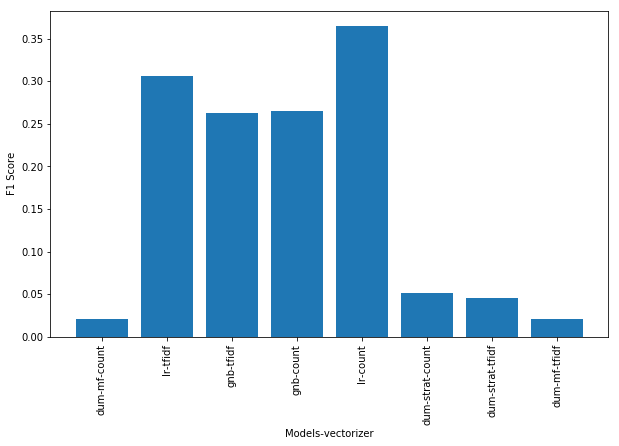

In [157]:
plt.figure(figsize=(10,6))
plt.bar(range(fin_result.shape[0]), fin_result['f1-score'])
plt.xticks(range(fin_result.shape[0]), list(fin_result.index), rotation=90)
plt.ylabel('F1 Score')
plt.xlabel('Models-vectorizer')

#### Best classifier: Logistic Regression

In [159]:
lr = LogisticRegression() # initializing model

In [160]:
lr.fit(train_text_count_vec, train_y) # training model

D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [161]:
pred = lr.predict(test_text_count_vec) # predicting on test

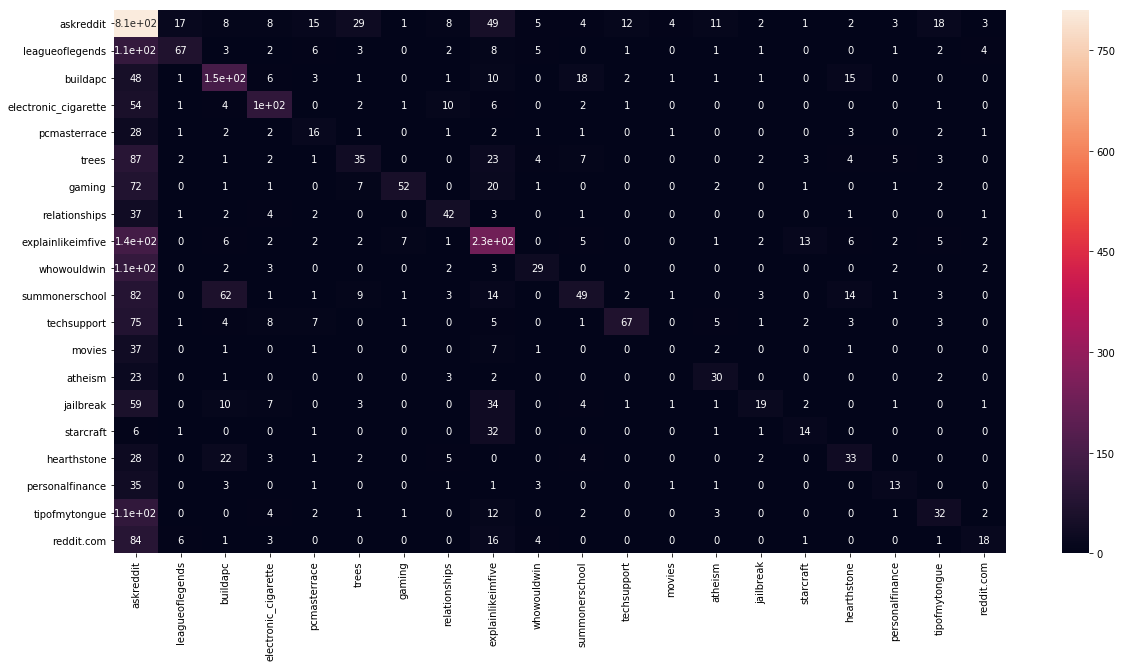

In [162]:
plt.figure(figsize = (20,10))

cm = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(cm, index = [i for i in top_20_cols],
                    columns = [i for i in top_20_cols])

sns.heatmap(df_cm, annot=True)

In [163]:
# f1 score per class
f1_scores_per_class = f1_score(test_y, pred, average=None)

Text(0.5, 0, 'subreddit classes')

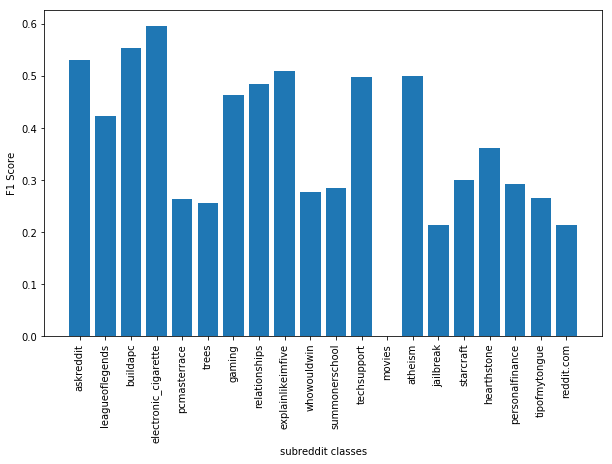

In [164]:
plt.figure(figsize=(10,6))
plt.bar(range(f1_scores_per_class.shape[0]),
        f1_scores_per_class)
plt.xticks(range(f1_scores_per_class.shape[0]),
           top_20_cols, rotation=90)
plt.ylabel('F1 Score')
plt.xlabel('subreddit classes')

#### Grid-Searching Logistic Regression

In [195]:
# initializing Vectorizer and Classifier
tfidf_vector = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), max_features=5000)
lr_clf = LogisticRegression()

In [166]:
powers_of_10 = []
powers_of_10.extend(10**x for x in range(-3, 4, 1))

In [167]:
pipe = Pipeline([
    ('lr', LogisticRegression())
])

In [197]:
params = {
    'lr__C': powers_of_10,
    'lr__solver':['newton-cg','saga','lbfgs'],
    'lr__multi_class': ['auto'],
}

In [198]:
grid_searching =  GridSearchCV(pipe, param_grid=params)

#### tf-Idf

In [199]:
tfidf_vec.fit_transform(
    train_fin.text.append(test_fin.text))
train_text_tfidf_vec = tfidf_vec.transform(train_fin.text)
test_text_tfidf_vec = tfidf_vec.transform(test_fin.text)

In [200]:
# training
grid_searching.fit(train_text_tfidf_vec, train_y)

D:\anaconda\envs\deep-work\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
D:\anaconda\envs\deep-work\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lr__multi_class': ['auto'], 'lr__solver': ['newton-cg', 'saga', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [201]:
grid_searching.best_params_

{'lr__C': 10, 'lr__multi_class': 'auto', 'lr__solver': 'lbfgs'}

In [202]:
# predicting the test values
pred = grid_searching.predict(test_text_tfidf_vec)

In [203]:
evaluate_func(test_y, pred)

Evaluating..
Accuracy Score  : 0.460
F1 Score        : 0.371
Precision Score : 0.480
Recall Score    : 0.338


(0.46, 0.37132250246402854, 0.4796964018301164, 0.3378594159985791)

In [228]:
# displaying all the wrong predictions

predictions = grid_searching.predict(test_text_tfidf_vec)
wrong_indexes = []
wrong_pred = []
wrong_true = []

for idx, (prediction, label) in enumerate(zip(predictions, test_y)):
    if prediction != label:
        wrong_indexes.append(idx)
        wrong_pred.append(prediction)
        wrong_true.append(label)

In [229]:
# creating a report of all
# the falsely classified `data`, `pred` and `true label`

error_report_df = pd.DataFrame(train_fin.text.iloc[wrong_indexes])
error_report_df['predicted'] =  wrong_pred
error_report_df['actual'] = wrong_true

error_report_df.columns = ['text', 'predicted', 'actual']

In [230]:
error_report_df.head(6)

,text,predicted,actual
0,think friend love hear talk -PRON- worth hanna...,askreddit,starcraft
1,good point definitely wanna friend aside stuff...,askreddit,starcraft
2,girl know -PRON- come friend like -PRON- redir...,askreddit,starcraft
3,great advice :) -PRON- pretty optimistic find ...,askreddit,starcraft
4,hannah like pretty shitty friend friendship li...,leagueoflegends,whowouldwin
5,yes -PRON- try talk calmly doe ... couple week...,askreddit,whowouldwin


From viewing the above error report, it is clear that the classifier would behave better with more intensive cleaning and removal of special characters from the text column.